# Global imports

In [1]:
import os
import shutil
import requests
import zipfile
from typing import List, Tuple, TypeAlias
from time import time as tt

import equinox as eqx
import jax.numpy as jnp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import Figure, Axes
from jax import block_until_ready

subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
latex_installed = shutil.which("latex") is not None
plt.rcParams.update({
    'text.usetex': latex_installed,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 15
})
def set_xlim(ax: Axes, xmin: float, xmax: float, border: float=0.02):
    xmin_margin =  xmin - (xmax-xmin)*border
    xmax_margin =  xmax + (xmax-xmin)*border
    ax.set_xlim(xmin_margin, xmax_margin)
def set_ylim(ax: Axes, ymin: float, ymax: float, border: float=0.02):
    ymin_margin =  ymin - (ymax-ymin)*border
    ymax_margin =  ymax + (ymax-ymin)*border
    ax.set_ylim(ymin_margin, ymax_margin)

# Wagner's LES
[Wagner's valibration repository](https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file)

## Download

In [2]:
do_run = False
if do_run:
    url = 'https://www.dropbox.com/scl/fi/8qwe9hf6wxc3w0crhzpml/profiles.zip?rlkey=sm8f7rhfokitzc7cgwinhip2k'
    url = url + '&dl=1'
    archive_file_name = 'tmp.zip'
    response = requests.get(url, allow_redirects=True)
    with open(archive_file_name, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(archive_file_name, 'r') as zipf:
        zipf.extractall()
    os.remove(archive_file_name)

## Global vairables

In [3]:
LES_TIMEFRAMES = [6, 12, 24, 48, 72]
LES_SPACE_STEPS = [1, 2, 4]
LES_FORCINGS = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

# link between Wagner's and Tunax names of the variables
LES_VAR_NAMES = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

# on which dimensions load the variables
LES_DIMS = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

LES_PATH = 'Wagner_LES'

OUTPUTS_PATH = 'k-epsilon_Wagner_LES'
os.makedirs(OUTPUTS_PATH, exist_ok=True)

## Rename folders and file

In [4]:
do_run = False
if do_run:
    os.rename('profiles', LES_PATH)
    for timeframe in LES_TIMEFRAMES:
        os.rename(os.path.join(LES_PATH, f'{timeframe}_hour_suite'), os.path.join(LES_PATH, f'{timeframe}h'))
        for space_step in LES_SPACE_STEPS:
            for forcing in LES_FORCINGS:
                os.rename(
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2'),
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                )
    os.remove(os.path.join(LES_PATH, 'getsuite.sh'))

## Forcings

In [5]:
def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

# Runs directs
## First Tunax implementation

In [6]:
do_run = False

from tunax import Obs, SingleColumnModel
from tunax.closures import KepsParameters

default_traj_path = os.path.join(OUTPUTS_PATH, 'default_traj')
os.makedirs(default_traj_path, exist_ok=True)

if do_run:
    pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS))
    for space_step in LES_SPACE_STEPS:
        for timeframe in LES_TIMEFRAMES:
            for forcing in LES_FORCINGS:
                jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                output_path = os.path.join(default_traj_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                os.makedirs(os.path.dirname(output_path), exist_ok = True)
                obs = Obs.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                # case corrections
                obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
                obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                # passive tracer forcing
                omega_p = 1/obs.metadatas['pt_timescale']
                lambda_c = obs.metadatas['pt_width']
                zc = obs.metadatas['pt_depth']
                l_z = obs.trajectory.grid.hbot
                wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt)
                obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

                # sunny forcing
                if forcing == 'strong_wind_and_sunny':
                    jb = obs.metadatas['sunny_flux']
                    eps1 = 0.6
                    lambda1 = 1.
                    lambda2 = 16.
                    b_str = obs.case.b_forcing[1]
                    wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                    obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny)
                    obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

                traj_wagner = obs.trajectory
                timeframe = float(traj_wagner.time[-1]/3600)
                dt = 10.
                out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                init_state = traj_wagner.extract_state(0)
                model = SingleColumnModel(timeframe, dt, out_dt, init_state, obs.case, 'k-epsilon', output_path, ['akt', 'akv'])

                keps_params = KepsParameters()

                model.compute_trajectory_with(keps_params)

                pbar.update(1)
    pbar.close()


4m50 avec modif de l'inversion tridiagonale mais sans la modif scan
?? avec modif de tracers mais sans modif inversion tridiag ni scan

## Tests on new implementation

In [3]:
from tunax import SingleColumnModel2, State, Grid, Case
from tunax.closures import KepsParameters, KepsState
import jax.numpy as jnp
nz = 100
grid = Grid.linear(nz, 100)
init_state = State(grid, jnp.zeros(nz), jnp.zeros(nz), t=jnp.zeros(nz))
case = Case()
model = SingleColumnModel2(100, 10., 10, init_state, case, closure_name='k-epsilon')
keps_params = KepsParameters()
closure_state = KepsState(grid, keps_params)
model.jit_run(keps_params)

Trajectory(
  grid=Grid(nz=100, hbot=f32[], zr=f32[100], zw=f32[101], hz=f32[100]),
  time=weak_f32[10],
  u=f32[10,100],
  v=f32[10,100],
  t=f32[10,100],
  s=None,
  b=None,
  pt=None,
  akv=None,
  akt=None
)

## Run with new implementation with no Jit

In [9]:
do_run = True

from tunax import Obs, SingleColumnModel2
from tunax.closures import KepsParameters

new_implement_traj_path = os.path.join(OUTPUTS_PATH, 'new_implementation_traj')
os.makedirs(new_implement_traj_path, exist_ok=True)
dt = 10.

if do_run:
    run_times = np.zeros((3, 5, 7))
    pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS))
    for i_s, space_step in enumerate(LES_SPACE_STEPS[2:]):
        for i_t, timeframe in enumerate(LES_TIMEFRAMES):
            for i_f, forcing in enumerate(LES_FORCINGS):
                
                jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                output_path = os.path.join(new_implement_traj_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                os.makedirs(os.path.dirname(output_path), exist_ok = True)
                obs = Obs.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                # case corrections
                obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
                obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                # passive tracer forcing
                omega_p = 1/obs.metadatas['pt_timescale']
                lambda_c = obs.metadatas['pt_width']
                zc = obs.metadatas['pt_depth']
                l_z = obs.trajectory.grid.hbot
                wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt)
                obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

                # sunny forcing
                if forcing == 'strong_wind_and_sunny':
                    jb = obs.metadatas['sunny_flux']
                    eps1 = 0.6
                    lambda1 = 1.
                    lambda2 = 16.
                    b_str = obs.case.b_forcing[1]
                    wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                    obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny)
                    obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

                traj_wagner = obs.trajectory
                nt = int(timeframe*3600/dt)
                out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                p_out = int(out_dt/dt)
                init_state = traj_wagner.extract_state(0)
                model = SingleColumnModel2(nt, dt, p_out, init_state, obs.case, 'k-epsilon', output_path, [])

                keps_params = KepsParameters()

                t = tt()
                traj = block_until_ready(model.run(keps_params))
                run_times[i_s, i_t, i_f] = tt() - t

                ds_traj = traj.to_ds()

                ds_traj.to_netcdf(output_path)

                pbar.update(1)
    pbar.close()


  0%|          | 0/105 [00:00<?, ?it/s]

3.34min -> lent puis rapide

ratio = 24

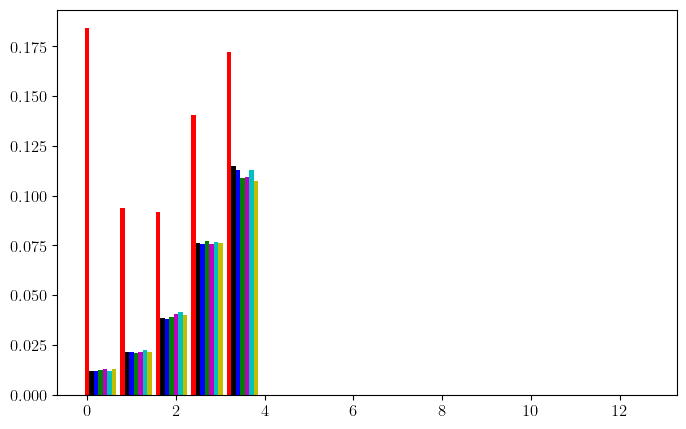

In [10]:
i_k = 0
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])
# plt.ylim(0, 1e-4)

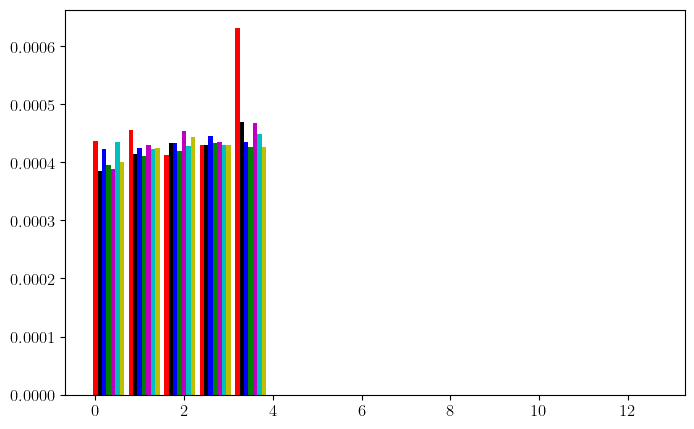

In [11]:
i_k = 1
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

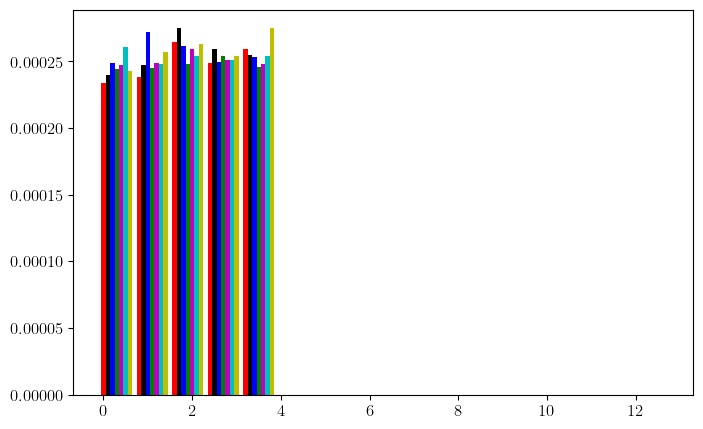

In [12]:
i_k = 2
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

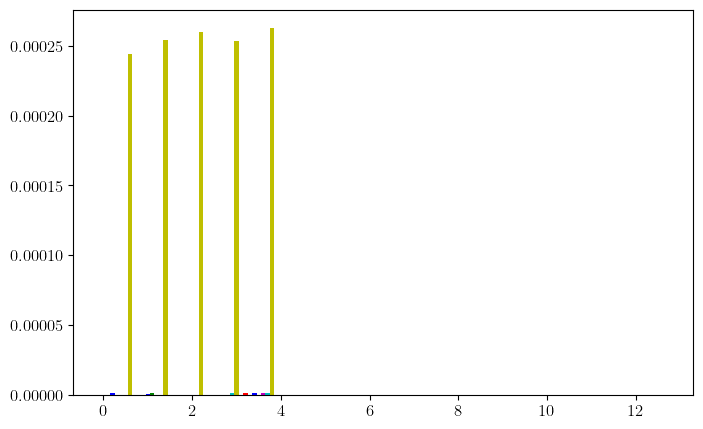

In [13]:
i_k = 3
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

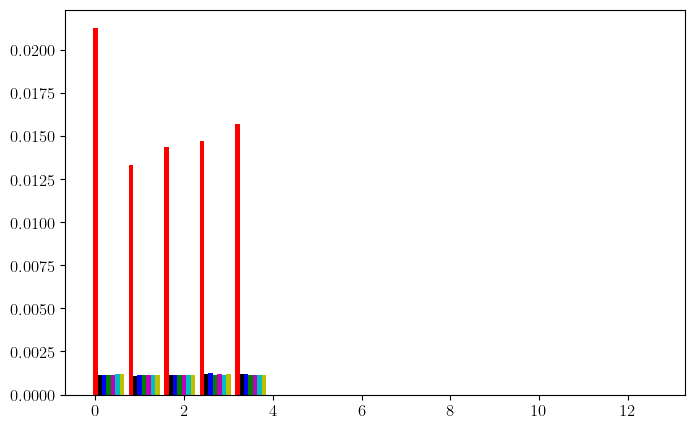

In [14]:
i_k = 4
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

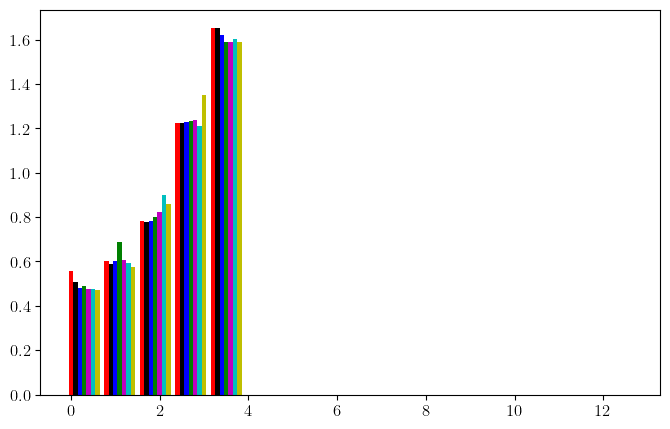

In [15]:
i_k = 5
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

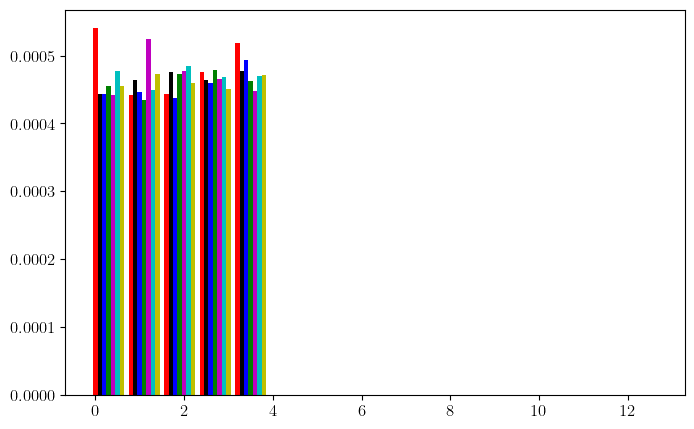

In [16]:
i_k = 6
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

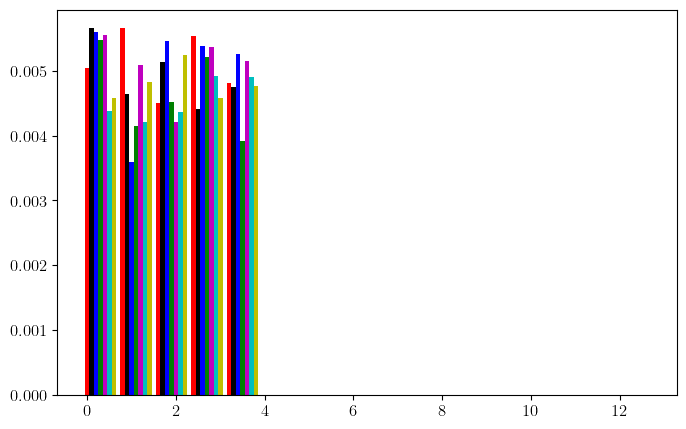

In [17]:
i_k = 7
colors = ['r', 'k', 'b', 'g', 'm', 'c', 'y']
width_f = .1
width_t = width_f*8
width_s = width_t*5.5

for i_s in range(3):
    for i_t in range(5):
        for i_f in range(7):
            plt.bar(i_s*width_s + i_t*width_t + i_f*width_f, times[i_k, i_s, i_t, i_f], width=width_f, color=colors[i_f])

# Huge plots of Wagner

In [9]:
titles = {
    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}


def plot_wag(timeframe, space_step):
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    fig, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing, forcing in enumerate(LES_FORCINGS):
        filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
        wagner_obs = Obs.from_jld2(filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        
        tunax_path = os.path.join(new_implement_traj_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axs_b[i_forcing].plot(wagner_traj.b[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_traj.b[-1, :], wagner_traj.grid.zr, 'r')
        axs_b[i_forcing].plot(tunax_ds.b[-1, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.u[-1, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(tunax_ds.u[-1, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.v[-1, :], wagner_traj.grid.zr, 'r--')
            axs_uv[i_forcing].plot(tunax_ds.v[-1, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_traj.pt[-1, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(tunax_ds.pt[-1, :], wagner_traj.grid.zr, 'g')
        axs_b[i_forcing].set_title(titles[LES_FORCINGS[i_forcing]])
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m', fontsize=18, horizontalalignment='center')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

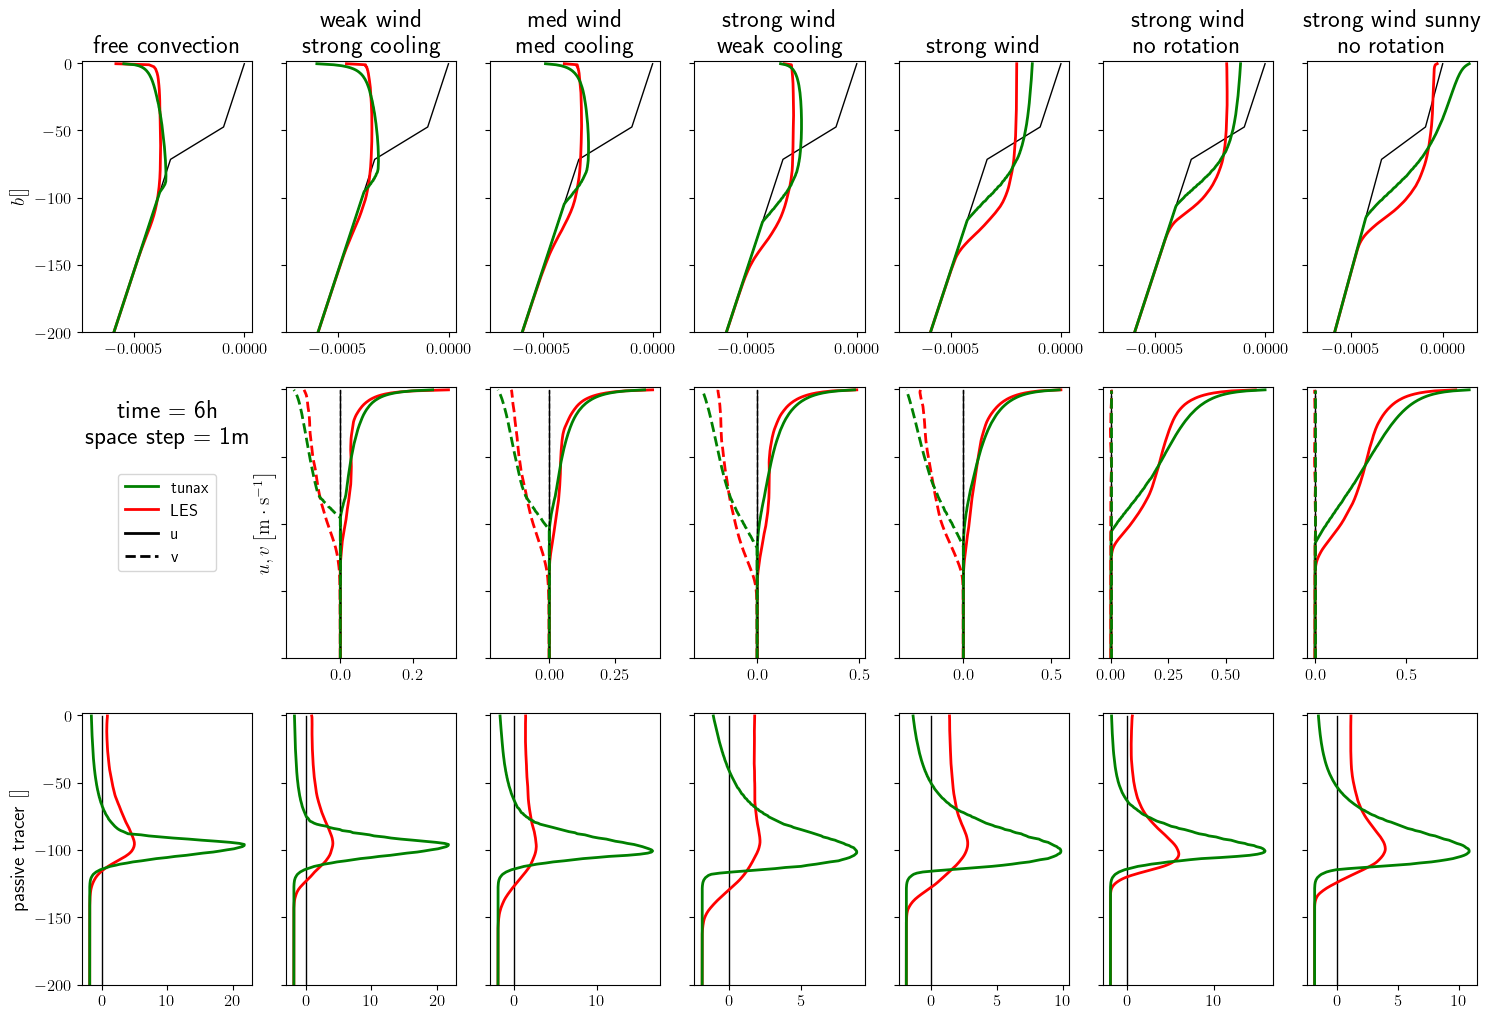

In [10]:
plot_wag(6, 1)

In [11]:
def plot_pt(timeframe, space_step, forcing):
    sp: subplot_1D_type = plt.subplots(1, 8, sharey=True, figsize=(20, 5))
    fig, axes = sp

    for i_plt_time in range(8):
        filename = os.path.join(
            'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
            f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
        wagner_obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory

        i_time = i_plt_time*wagner_traj.time.shape[0]//8
        
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axes[i_plt_time].plot(wagner_traj.b[i_time, :], wagner_traj.grid.zr, 'r')
        axes[i_plt_time].plot(tunax_ds.b[i_time, :], wagner_traj.grid.zr, 'g')
        axes[i_plt_time].set_title(f'time = {wagner_traj.time[i_time]/3600: .2f}h')
    axes[0].plot([], [], 'g', label='tunax')
    axes[0].plot([], [], 'r', label='LES')
    fig.suptitle(f'time = {timeframe}h, space step = {space_step}m, {forcing}, passive tracer')
    axes[0].legend()
    

In [12]:
import xarray as xr
timeframe = 6
space_step = 1
forcing = 'free_convection'
tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
tunax_ds = xr.load_dataset(tunax_path)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/admin-mouttaga/Codes/repositories/tunax/dev_experiments/k-epsilon_Wagner_LES/tunax_scm_output/default_keps/1m_6h_free_convection.nc'

In [ ]:
tunax_ds.akt

<xarray.DataArray 'akt' (time: 36, zw: 257)> Size: 37kB
array([[9.9999997e-06, 9.9999997e-06, 9.9999997e-06, ..., 9.9999997e-06,
        9.9999997e-06, 9.9999997e-06],
       [6.5345041e-05, 6.5130000e-05, 6.4699911e-05, ..., 1.2271570e-02,
        7.5802701e-03, 5.2346205e-03],
       [6.5345041e-05, 6.5130000e-05, 6.4699911e-05, ..., 1.6346352e-02,
        9.1146966e-03, 5.4988684e-03],
       ...,
       [8.0458485e-05, 7.5205629e-05, 6.4699911e-05, ..., 3.8084377e-02,
        1.4749830e-02, 3.0825567e-03],
       [8.0458485e-05, 7.5205629e-05, 6.4699911e-05, ..., 3.8278706e-02,
        1.4808732e-02, 3.0737445e-03],
       [8.0458485e-05, 7.5205629e-05, 6.4699911e-05, ..., 3.8825493e-02,
        1.4858333e-02, 2.8747525e-03]], dtype=float32)
Coordinates:
  * time     (time) float32 144B 0.0 600.0 1.2e+03 ... 1.98e+04 2.04e+04 2.1e+04
  * zw       (zw) float32 1kB -256.0 -253.7 -251.4 -249.2 ... -1.539 -0.7697 0.0

In [ ]:
from tunax import diffusion_solver, Grid
from jax import vmap
import matplotlib.pyplot as plt


def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

grid = Grid(obs.trajectory.grid.zr, obs.trajectory.grid.zw)#

omega_p = 1/900.
lambda_c = 8.
zc = obs.metadatas['pt_depth']
l_z = 96.
wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
vec_fun = vmap(wrapped_forcing_pt)

dt = 10.

pt = jnp.zeros(grid.nz)

for i in range(2160):
    df = grid.hz*vec_fun(grid.zr)
    df = grid.hz*pt + dt*df
    time_nearest = dt*((i-1)//60+1)*60
    
    # time_nearest = tunax_ds.time.sel(time=time, method='nearest')
    print(float(time_nearest))
    akt = jnp.array(tunax_ds.akt.sel(time = time_nearest))
    pt = diffusion_solver(akt, grid.hz, df, dt)

plt.plot(pt, grid.zr)

0.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
600.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1200.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0
1800.0

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

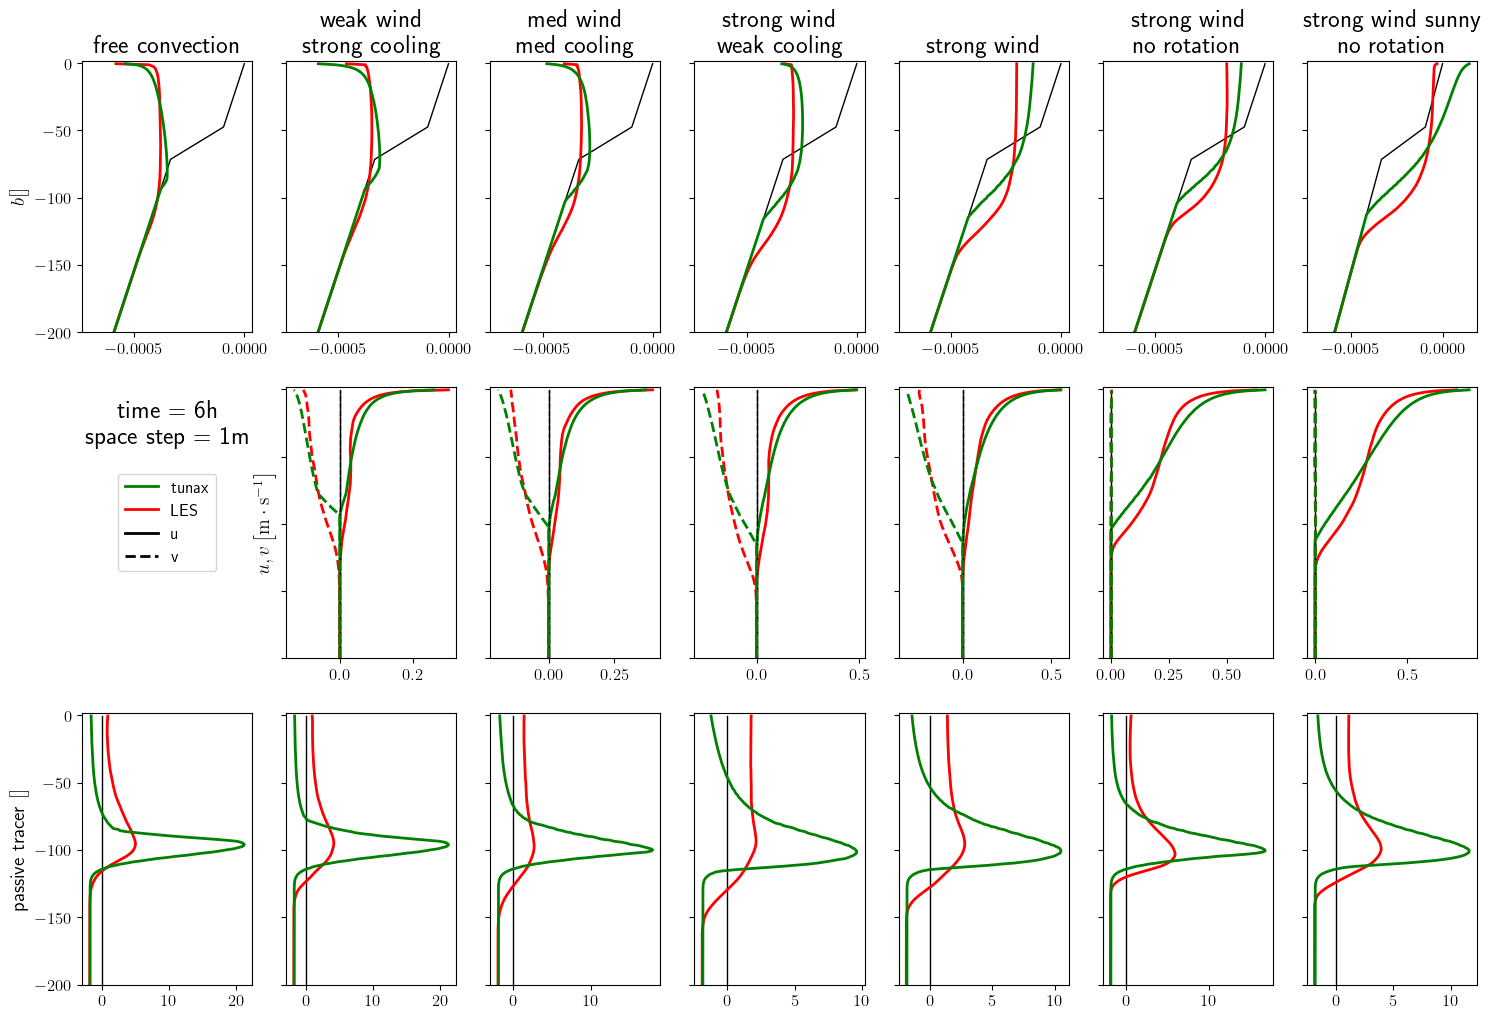

In [ ]:
plot_wag(6, 1)

In [ ]:
plot_wag(12, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_forma

Error in callback <function _draw_all_if_interactive at 0x301c2ea20> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]
           ^
ParseSyntaxException: Expected '\\right', found '\'  (at char 11), (line:1, col:12)

ValueError: 
u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]
           ^
ParseSyntaxException: Expected '\\right', found '\'  (at char 11), (line:1, col:12)

<Figure size 1800x1200 with 21 Axes>

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


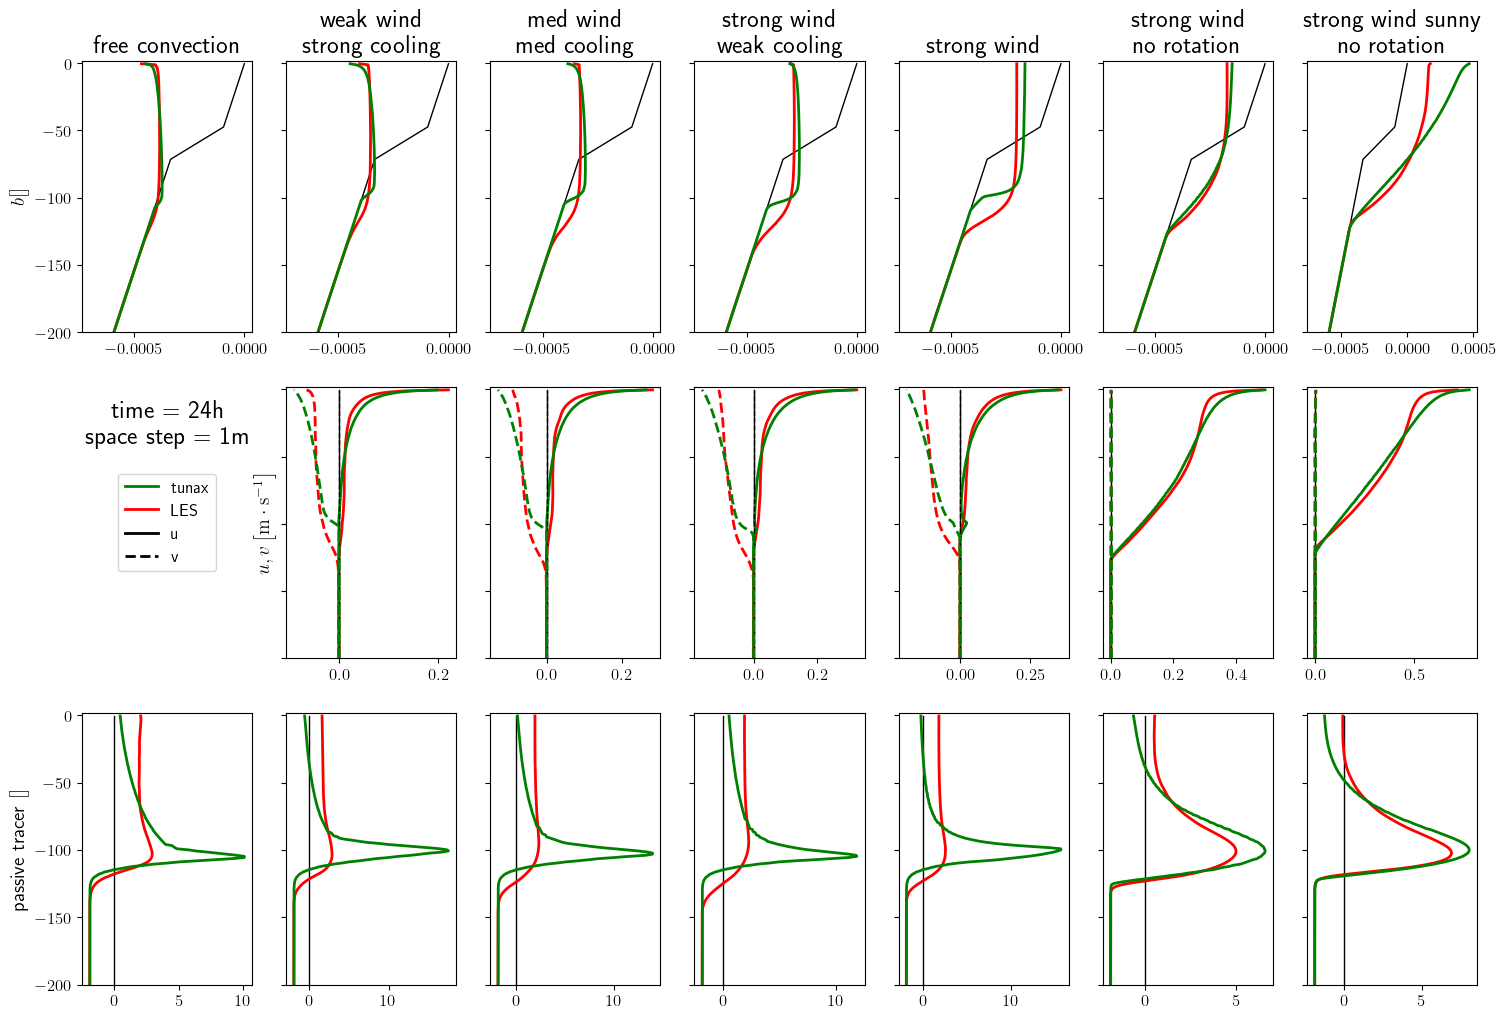

In [ ]:
plot_wag(24, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


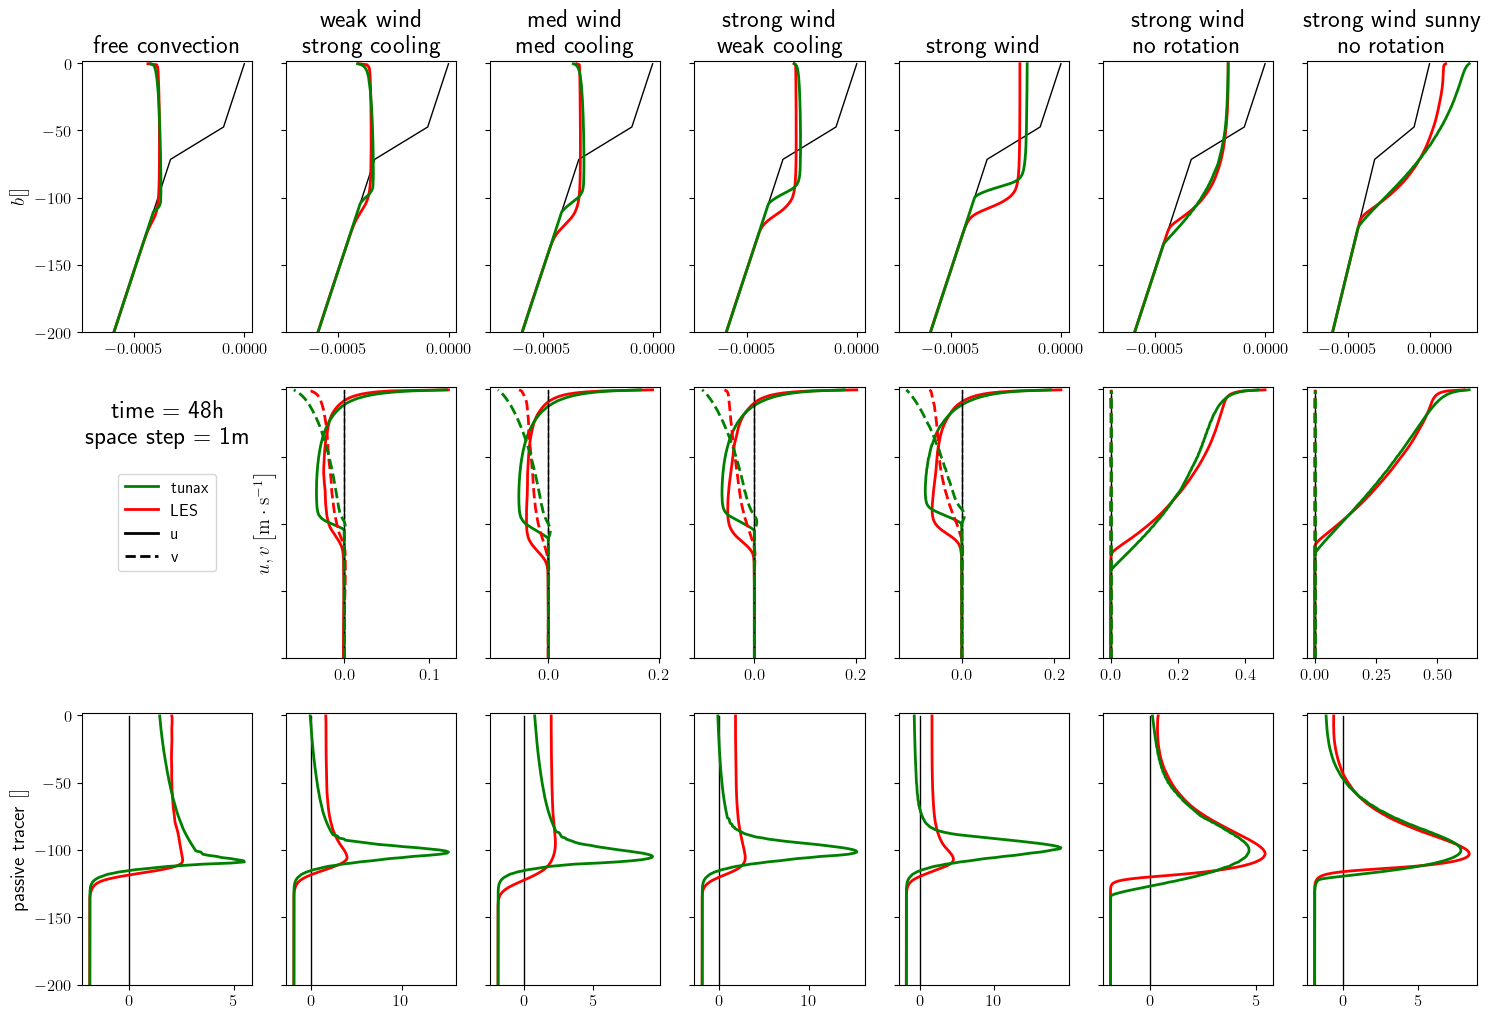

In [ ]:
plot_wag(48, 1)

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""


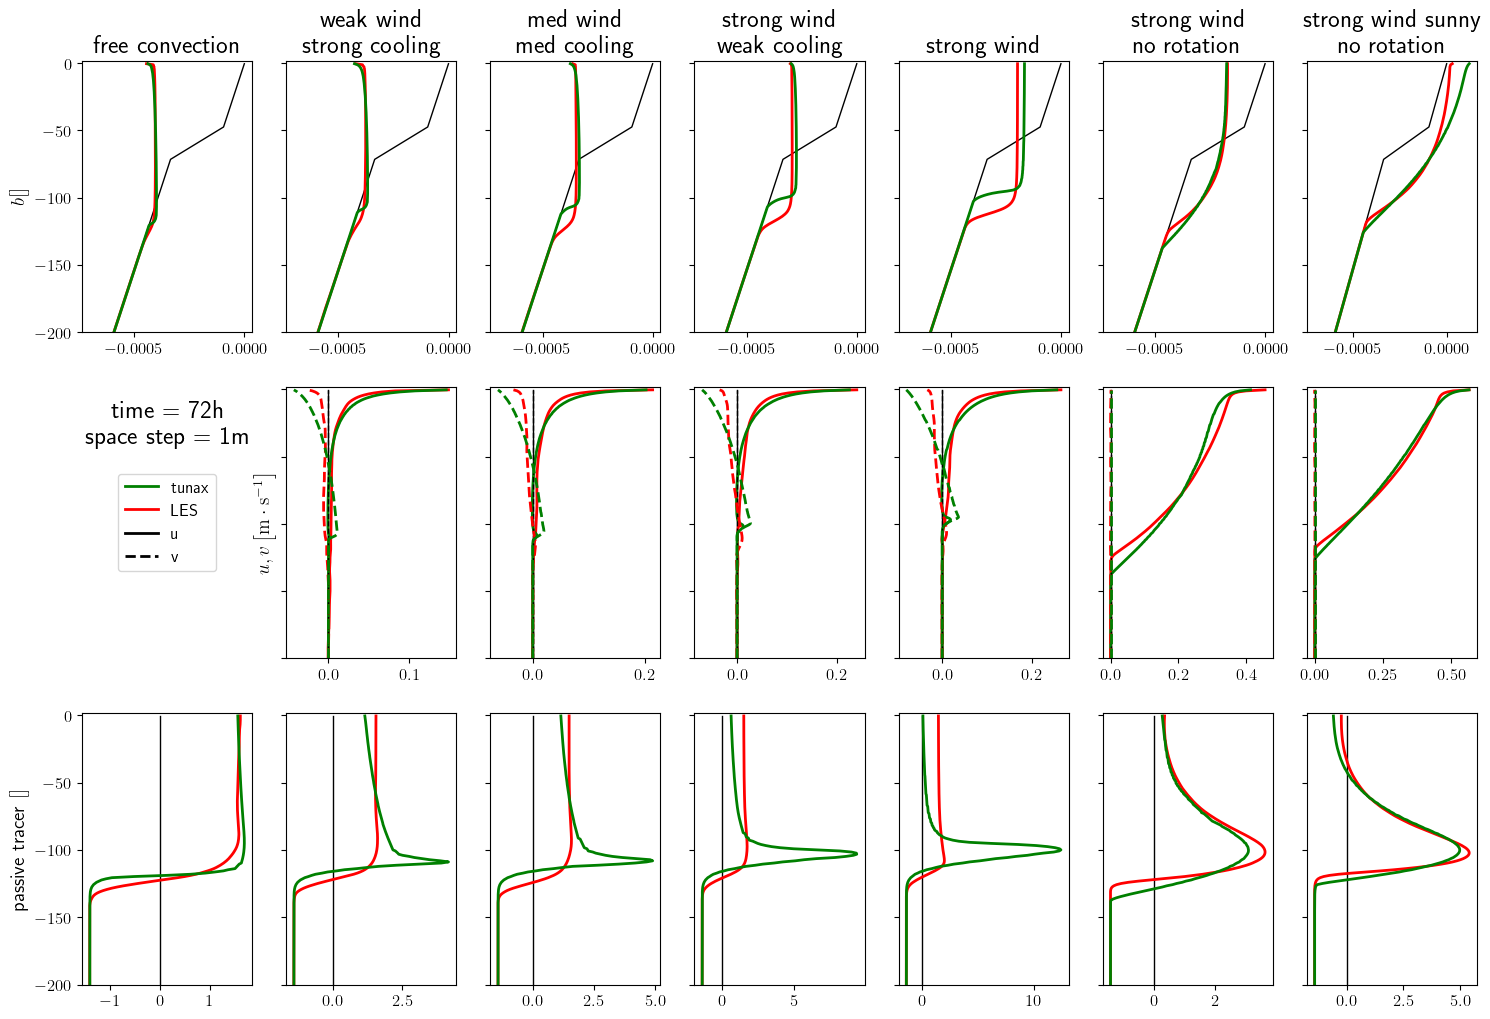

In [ ]:
plot_wag(72, 1)

# Calibration fonction de coût

In [ ]:
timeframe_list = [6, 12, 24, 48, 72]
space_step_list = [1, 2, 4]
forcing_list = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

var_names = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

dims = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

In [ ]:
import os
from typing import List

import equinox as eqx
import jax.numpy as jnp
from jaxtyping import Float, Array

from tunax import Obs, Database, FittableParameter, FittableParametersSet, Trajectory, Fitter

# create the database
observations = []
weights = []
variables = []
space_step = 4
for timeframe in timeframe_list:
    for forcing in forcing_list:
        filename = os.path.join(
            'k-epsilon_Wagner_LES', 'Wagner_LES',f'{timeframe}_hour_suite',
            f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2')
        obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)

        # case corrections
        obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
        obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']))
        obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

        # passive tracer forcing
        omega_p = 1/obs.metadatas['pt_timescale']
        lambda_c = obs.metadatas['pt_width']
        zc = obs.metadatas['pt_depth']
        l_z = obs.trajectory.grid.hbot
        wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
        obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt)
        obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

        # sunny forcing
        if forcing == 'strong_wind_and_sunny':
            jb = obs.metadatas['sunny_flux']
            eps1 = 0.6
            lambda1 = 1.
            lambda2 = 16.
            b_str = obs.case.b_forcing[1]
            wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny)
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)
        
        # weight of the observation
        if forcing == 'free_convection':
            weights.append(1.)
            variables.append(['b', 'pt'])
        elif forcing in ['strong_wind_no_rotation', 'strong_wind_and_sunny']:
            weights.append(2/3)
            variables.append(['b', 'pt', 'u'])
        else:
            weights.append(1/2)
            variables.append(['b', 'pt', 'u', 'v'])
        observations.append(obs)
metadatas = {'weights': weights, 'variables': variables}
database = Database(observations, metadatas)

# fonction de normalisation d'un array
def norm_array(x: Float[Array, 'nz']):
    return (x-x.mean())/x.std()

# indices de la zone à sélectionner (pour le space step donné)
grid = database.observations[0].trajectory.grid
i_bot = jnp.searchsorted(grid.zr, grid.hbot/3, side='right')
i_top = jnp.searchsorted(grid.zr, -4, side='left')

# fonction coût
def loss(scm_set: List[Trajectory], database: Database):
    cost = 0.
    for i_obs in range(1):#len(scm_set)-34):
        traj_scm = scm_set[i_obs]
        traj_obs = database.observations[i_obs].trajectory
        for var in database.metadatas['variables'][i_obs]:
            var_scm = getattr(traj_scm, var)
            var_obs = getattr(traj_obs, var)
            end_scm = var_scm[-1, i_bot:i_top]
            end_obs = var_obs[-1, i_bot:i_top]
            norm_scm = norm_array(end_scm)
            norm_obs = norm_array(end_obs)
            var_cost = jnp.sum((norm_scm-norm_obs)**2)
            cost += database.metadatas['weights'][i_obs]*var_cost
    return cost

# parameters on the parameters to calibrate
c_eps1_par = FittableParameter(True, val=1.44)
c_eps2_par = FittableParameter(True, val=1.92)
c_eps3m_par = FittableParameter(True, val=.4)
c_eps3p_par = FittableParameter(True, val=1.)
sig_k_par = FittableParameter(True, val=1.)
sig_eps_par = FittableParameter(True, val=1.3)
coef_dico = {
    'c_eps1': c_eps1_par,
    'c_eps2': c_eps2_par,
    'c_eps3m': c_eps3m_par,
    'c_eps3p': c_eps3p_par,
    'sig_k': sig_k_par,
    'sig_eps': sig_eps_par
}
coef_fit_params = FittableParametersSet(coef_dico, 'k-epsilon')

/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:202: UserWarning: Wrong type for the focring of pt in the initialisation of Case instance.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:163: UserWarning: The forcing of tracer b wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_format_to_single_line(f"""
/Users/admin-mouttaga/Codes/tunax/tunax/case.py:176: UserWarning: The forcing of the passive tracer wasn't set at the initialisation of the Case instance, it is set to 0.
  warnings.warn(_forma

In [ ]:

nloop = 5
learning_rate = .1
dt =100.
verbatim = True
nit_loss = 2
f = Fitter(coef_fit_params, database, dt, loss, nloop, nit_loss, learning_rate, verbatim, 'test.npz')


/Users/admin-mouttaga/Codes/tunax/tunax/model.py:142: UserWarning: The `time_frame`is not proportional to the out time-step `out_dt`, the last step will be computed a few before the `time_frame`.
  warnings.warn(_format_to_single_line("""
/Users/admin-mouttaga/Codes/tunax/tunax/model.py:148: UserWarning: The `time_frame`is not proportional to the time-step `dt`, the last step will be computed a few before the time_frame.
  warnings.warn(_format_to_single_line("""


In [ ]:
coefs = f()


                    loop 0
                    x [1.44 1.92 0.4  1.   1.   1.3 ]
                    grads [ 0.          1.586294    0.00658472 -1.8148556  -0.04414263  1.0162772 ]
                

                    loop 1
                    x [1.44       1.8200006  0.30000082 1.0999993  1.0999993  1.2000006 ]
                    grads [ 0.         -0.27985045 -0.00968565  0.44531986  0.82280415 -0.20055579]
                

                    loop 2
                    x [1.44       1.7669499  0.32389024 1.1473308  1.0292809  1.1486785 ]
                    grads [ 0.         -3.110468   -0.02530866  3.6784928   2.0768275  -1.6100436 ]
                

                    loop 3
                    x [1.44       1.8048443  0.3896227  1.1069242  0.94974715 1.1809658 ]
                    grads [ 0.         -0.25618383 -0.00930703  0.4328802   0.8048458  -0.1453691 ]
                

                    loop 4
                    x [1.44       1.8400438  0.4591009  1.0679388  0

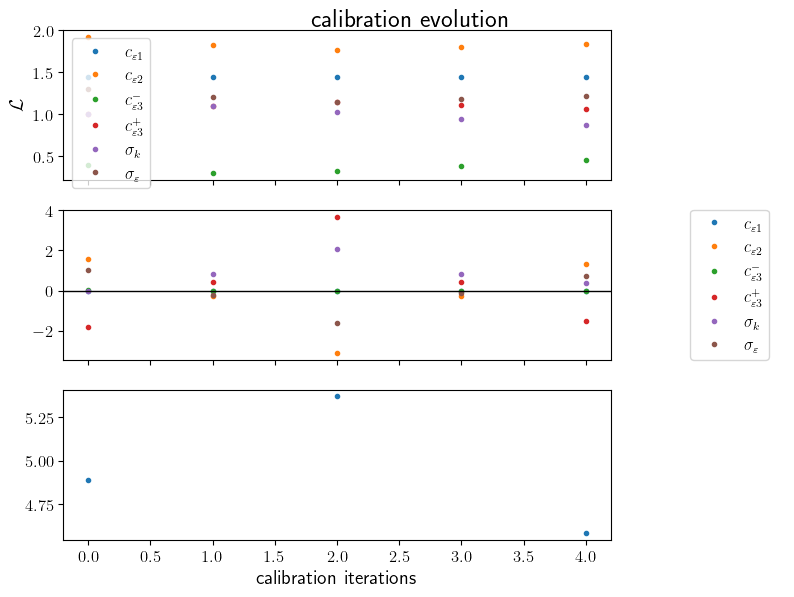

In [ ]:
import numpy as np
data = np.load('test.npz', allow_pickle=True)
loss_it = data['loss_it']
loss_values = data['loss_values']

sp: subplot_2D_type = plt.subplots(3, 2, sharex=True, figsize=(8, 6), width_ratios=(5, 1))
fig, [[ax_x, ax1], [ax_g, ax_leg], [ax_l, ax2]] = sp
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

par_names = [
    r'$c_{\varepsilon 1}$',
    r'$c_{\varepsilon 2}$',
    r'$c_{\varepsilon 3}^-$',
    r'$c_{\varepsilon 3}^+$',
    r'$\sigma_k$',
    r'$\sigma_\varepsilon$'
]

for i_par in range(data['x'].shape[0]):
    ax_x.plot(data['x'][i_par, :], '.', label=par_names[i_par])
    ax_leg.plot([], [], '.', label=par_names[i_par])
    ax_g.plot(data['grads'][i_par, :], '.')
ax_g.axhline(0, color='k', linewidth=1)
ax_l.plot(loss_it, loss_values, '.', label=r'$\mathcal L$')

ax_l.set_xlabel('calibration iterations')
ax_x.legend()
ax_x.set_ylabel(r'parameters $c$ calibration')
ax_x.set_ylabel(r'$partial_c \mathcal L$')
ax_x.set_ylabel(r'$\mathcal L$')
fig.suptitle(r'calibration evolution')

ax_leg.legend(loc='center')
ax1.axis('off')
ax_leg.axis('off')
ax2.axis('off')

plt.show()
